# Texas Infltaion prediction

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/discussion/276912

https://fred.stlouisfed.org/series/DFII10#0

https://fred.stlouisfed.org/categories/22

future rate
oil
commodity
food
stockmarket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import plotly.express as px

from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sktime
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

!pip install sktime[all_extras]

# 1. Load data

https://data.texas.gov/dataset/Key-Economic-Indicators/karz-jr5v

In [2]:
data = pd.read_csv('data/Key_Economic_Indicators.csv')
data = data.iloc[:-2,:]

In [3]:
data.head()

,Month,Year,Consumer Confidence Index TX,Consumer Confidence West South Central,Consumer Confidence Index US,PCE Deflator,Consumer Price Index TX,Consumer Price Index U.S.,CPI U.S. Ex Food and Energy,Nonfarm Employment TX,...,Retail Diesel Price TX,Nonfarm Employment Illinois,Nonfarm Employment Florida,Nonfarm Employment New York,Nonfarm Employment Texas,Nonfarm Employment California,Gross Value Crude Oil Production,Gross Value Natural Gas Production,Motor Fuel Taxed Gasoline,Motor Fuel Taxed Diesel
0,1,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"5,829.6","7,650.2","8,490.6","9,642.4","14,881.8",NaN,NaN,NaN,NaN
1,2,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"5,836.2","7,670.7","8,487.9","9,653.2","14,908.3",NaN,NaN,NaN,NaN
2,3,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"5,833.8","7,668.7","8,483.6","9,670.8","14,929.3",NaN,NaN,NaN,NaN
3,4,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"5,857.5","7,716.4","8,518.6","9,715.1","14,979.4",NaN,NaN,NaN,NaN
4,5,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"5,855.4","7,753","8,509.9","9,727.1","14,985.4",NaN,NaN,NaN,NaN


In [4]:
data.shape

(210, 31)

In [5]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '')
        data[col] = data[col].astype(float)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Month                                   210 non-null    int64  
 1   Year                                    210 non-null    int64  
 2   Consumer Confidence Index TX            121 non-null    float64
 3   Consumer Confidence West South Central  186 non-null    float64
 4   Consumer Confidence Index US            186 non-null    float64
 5   PCE Deflator                            113 non-null    float64
 6   Consumer Price Index TX                 186 non-null    float64
 7   Consumer Price Index U.S.               186 non-null    float64
 8   CPI U.S. Ex Food and Energy             113 non-null    float64
 9   Nonfarm Employment TX                   186 non-null    float64
 10  Nonfarm Employment U.S.                 186 non-null    float6

In [7]:
data.isna().sum()

Month                                      0
Year                                       0
Consumer Confidence Index TX              89
Consumer Confidence West South Central    24
Consumer Confidence Index US              24
PCE Deflator                              97
Consumer Price Index TX                   24
Consumer Price Index U.S.                 24
CPI U.S. Ex Food and Energy               97
Nonfarm Employment TX                     24
Nonfarm Employment U.S.                   24
Unemployment TX                           24
Unemployment U.S.                         24
Single Family Building Permits TX         25
Multi Family Building Permits TX          25
Existing Single Family Home Sales TX      25
Existing Single Family Home Price TX      25
Non Residential Building Construction     24
Total Sales Tax Collections Retail TX     24
Total Sales Tax Collections TX            24
Retail Gasoline Price TX                  24
Retail Diesel Price TX                    24
Nonfarm Em

In [8]:
data['datetime']= data['Month'].astype('str') + '-' + data['Year'].astype('str')
data['datetime']= pd.to_datetime(data['datetime'])
data.set_index(['datetime'], inplace= True)
# I need to add the initial
data.index = pd.PeriodIndex(data.index, freq="M")
data.index[:5]

PeriodIndex(['2005-01', '2005-02', '2005-03', '2005-04', '2005-05'], dtype='period[M]', name='datetime')

In [9]:
# one month difference in CPI
data['diff_1'] = data['Consumer Price Index TX'] - data['Consumer Price Index TX'].shift(1)

# 2. Explanatory Data Analysis

In [129]:
train = data.iloc[:-24,:]['2007-01-01':]
val = data.iloc[-24:-12,:]
test = data.iloc[-12:,:]
y_data = data['Consumer Price Index TX']['2007-01-01':]
y_train = train['Consumer Price Index TX']
y_val = val['Consumer Price Index TX']
y_test = test['Consumer Price Index TX']
train.shape, val.shape, test.shape

((162, 32), (12, 32), (12, 32))

## 2.1. Monthly Texas Consumer Price Index (CPI) Inflation

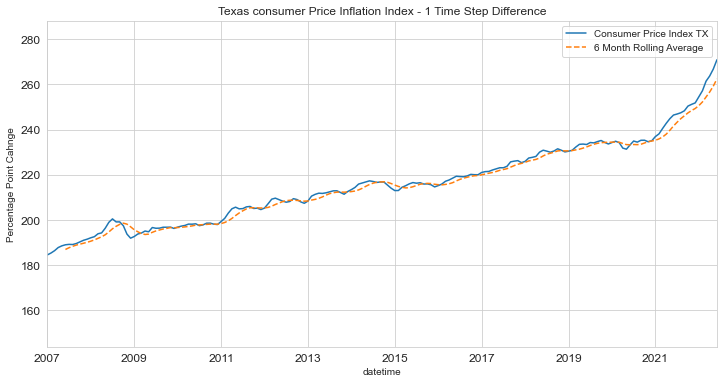

In [11]:
fig, ax = plt.subplots()

title='Texas consumer Price Inflation Index - 1 Time Step Difference'
ylabel='Percentage Point Cahnge'
xlabel='Month'

mean = data['Consumer Price Index TX'].mean()
sd = data['Consumer Price Index TX'].std()
median = data['Consumer Price Index TX'].median()

x_begin = '2007-01-01'
x_end = '2022-06-01'


ax = data['Consumer Price Index TX'].plot(xlim=[x_begin,x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title,legend = True,fontsize=12)
ax.set(xlabel=xlabel, ylabel=ylabel);

data['Consumer Price Index TX'].rolling(window=6).mean().plot(xlim=[x_begin,x_end],linestyle='--' , fontsize=12);

ax.legend(['Consumer Price Index TX', '6 Month Rolling Average']);

In [ ]:
# # Interactive plot of time series
# # ==============================================================================
# data.loc[:-24, 'partition'] = 'train'
# data.loc[-24:-12, 'partition'] = 'validation'
# data.loc[-12:, 'partition'] = 'test'
#
# fig = px.line(
#     data_frame = data['2007-01-01':].reset_index(),
#     x      = 'datetime',
#     y      = 'Consumer Price Index U.S.',
#     color  = 'partition',
#     title  = 'Number of users',
#     width  = 900,
#     height = 500
# )
#
# # fig.update_xaxes(
# #     rangeslider_visible=True,
# #     rangeselector=dict(
# #         buttons=list([
# #             dict(count=1, label="1m", step="month", stepmode="backward"),
# #             dict(count=6, label="6m", step="month", stepmode="backward"),
# #             dict(count=1, label="YTD", step="year", stepmode="todate"),
# #             dict(count=1, label="1y", step="year", stepmode="backward"),
# #             dict(step="all")
# #         ])
# #     )
# # )
#
# fig.show()
#
# data=data.drop(columns='partition')

Now I am going to forget that I have seen this graph and focus only train and validation set.

## 2.2. Texas CPI - monthly difference

Now I am going to calculate and plot the monthly difference in Tax.

In [ ]:
title='Texas consumer Price Inflation Index - 1 Time Step Difference'
ylabel='Percentage Point Cahnge'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

mean = data['diff_1'].mean()
sd = data['diff_1'].std()

ax = data['diff_1'].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

data['diff_1'].rolling(window=6).mean().plot(xlim=[x_begin, x_end],linestyle='--');

ax.legend(['Consumer Price Index TX', '6 Month Rolling Average']);

## 2.3. Texas CPI - US CPI

In [ ]:
title= 'Texas CPI vs US CPI'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'Consumer Price Index U.S.']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

data[columns[1]].plot(xlim=[x_begin, x_end])

ax.legend(['Consumer Price Index TX', 'Consumer Price Index U.S.']);

## 2.4. Texas CPI vs Texas Unemployment Rate

In [ ]:
title= 'Texas CPI vs Texas Unemployment Rate'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'Unemployment TX']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

data[columns[1]].plot(xlim=[x_begin, x_end],secondary_y=True)

ax.legend(['Consumer Price Index TX', 'Unemployment TX']);

## 2.5. Texas CPI vs Existing Single Family Home Sales TX

In [ ]:
title= 'Texas CPI vs Existing Single Family Home Sales TX'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'Existing Single Family Home Sales TX']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

data[columns[1]].plot(xlim=[x_begin, x_end],secondary_y=True)

ax.legend(['Consumer Price Index TX', 'Existing Single Family Home Sales TX']);

## 2.6. Texas CPI vs Total Sales Tax Collections TX

In [ ]:
title= 'Texas CPI vs Total Sales Tax Collections TX'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'Total Sales Tax Collections TX']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

ax = data[columns[1]].plot(xlim=[x_begin, x_end],secondary_y=True)

ax.legend(['Consumer Price Index TX', 'Total Sales Tax Collections TX']);

## 2.7. Texas CPI vs Retail Gasoline Price TX

In [ ]:
title= 'Texas CPI vs Retail Gasoline Price TX'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'Retail Gasoline Price TX']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-4*sd,mean+4*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

ax = data[columns[1]].plot(xlim=[x_begin, x_end],secondary_y=True)

ax.legend(['Consumer Price Index TX', 'Total Sales Tax Collections TX']);

# 3. Statistical Analysis

## 3.1. Texas CPI Trend - Hodrick-Prescott filter

The <a href='https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter'>Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

x_begin = '2007-01-01'
x_end = '2020-06-01'

inf_cycle, inf_trend = hpfilter(data['Consumer Price Index TX'][x_begin:x_end], lamb=1200)
data['inf_trend'] = inf_trend

In [ ]:
title= 'Texas CPI vs Retail Gasoline Price TX'
ylabel='Inflation'
xlabel='Month'

x_begin = '2007-01-01'
x_end = '2020-06-01'

fig, ax = plt.subplots()

columns = ['Consumer Price Index TX', 'inf_trend']

mean = data[columns[0]].mean()
sd = data[columns[0]].std()

ax = data[columns[0]].plot(xlim=[x_begin, x_end],ylim=[mean-2*sd,mean+2*sd],figsize=(12,6),title=title)
ax.set(xlabel=xlabel, ylabel=ylabel);

ax = data[columns[1]].plot(xlim=[x_begin, x_end])

ax.legend(['Consumer Price Index TX', 'Total Sales Tax Collections TX']);

## 3.2. Seasonal Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

x_begin = '2007-01-01'
x_end = '2020-06-01'

plt.rcParams["figure.figsize"] = (12, 12)

result = seasonal_decompose(data['Consumer Price Index TX'][x_begin:x_end], model='multiplicative')
result.plot();

## 3.3. lag plot

In [ ]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = (8, 8)

ax = lag_plot(data['Consumer Price Index TX'])
ax.title.set_text('Texas CPI Lag Plot')

## 3.3. Autocorrelation Plot

As we can see there is strong correlation with previous time steps.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
title = 'Autocorrelation: CPI TX'
lags = 40

plt.rcParams["figure.figsize"] = (12, 8)

x_begin = '2007-01-01'

plot_acf(train['Consumer Price Index TX'][x_begin:],title=title,lags=lags);

## 3.5. Partial Autocorrelation Plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
title='Partial Autocorrelation: Daily Female Births'
lags = 40

plt.rcParams["figure.figsize"] = (12, 8)

x_begin = '2007-01-01'

plot_pacf(train['Consumer Price Index TX'][x_begin:].dropna(),title=title,lags=lags);

In [ ]:
title='Partial Autocorrelation: Daily Female Births'
lags = 20

plt.rcParams["figure.figsize"] = (12, 8)

x_begin = '2007-01-01'

plot_acf(train['diff_1'][x_begin:].dropna(),title=title,lags=lags);

## 3.6. Augmented Dickey-Fuller Test
To determine whether a series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('Augmented Dickey-Fuller Test Customer Price Index TX:')

x_begin = '2017-01-01'

dftest = adfuller(train['Consumer Price Index TX'][x_begin:],autolag='BIC')
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,value in dftest[4].items():
    dfout[f'critical value ({key})']=value
print(dfout)

The p-value is less than 0.05, so we can reject the null hypothesis that the series is stationary.

## 3.7 Seasonal amd Monthly Average

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

x_begin = '2017-01-01'

month_plot(train['Consumer Price Index TX'][x_begin:]);

In [ ]:
from statsmodels.graphics.tsaplots import quarter_plot

x_begin = '2017-01-01'

quarter_plot(train['Consumer Price Index TX'][x_begin:].resample(rule='Q').mean());

diff month plot

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

x_begin = '2017-01-01'

month_plot(train['diff_1'][x_begin:]);

In [ ]:
from statsmodels.graphics.tsaplots import quarter_plot

x_begin = '2017-01-01'

quarter_plot(train['diff_1'][x_begin:].resample(rule='Q').mean());

# Feature Engineering

In [ ]:
from tsfresh import extract_features

In [ ]:
x_begin = '2007-01-01'
ts_df = train[x_begin:][['Consumer Price Index TX','Consumer Price Index U.S.']]
ts_df['id'] = 0
features = extract_features(ts_df, column_id='id')

In [ ]:
features

# 4. Forecasting

General notebook on things that can be donewith time series
https://www.kaggle.com/code/thebrownviking20/everything-you-can-do-with-a-time-series/notebook

In [21]:
def error_func(y_true, y_pred):
    print("mean absolute error :", mean_absolute_error(y_true, y_pred))
    print("mean root square error:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("mean absolute percentage error", mean_absolute_percentage_error(y_true, y_pred))

In [22]:
def error_list(y_true, y_pred):
    return [mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred)),mean_absolute_percentage_error(y_true, y_pred)]

In [23]:
error_df = pd.DataFrame(columns=['mean absolute error', 'mean root square error','mean absolute percentage error'])

## 4.1. Base forecast
val_pred = data.iloc[-36:-24, :]

val_pred = val_pred.reset_index(drop=True).set_index(data.iloc[-24:-12, :].index)
x_begin = '2017-01-01'


In [ ]:
val_pred = data.iloc[-36:-24,:]

val_pred = val_pred.reset_index(drop=True).set_index(data.iloc[-24:-12,:].index)

In [ ]:
x_begin = '2017-01-01'

train['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')

val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred['Consumer Price Index TX'].plot(legend=True,label='predictions');

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred['Consumer Price Index TX'])

In [ ]:
print("mean absolute error :", mean_absolute_error(val['Consumer Price Index TX'], val_pred['Consumer Price Index TX']))
print("mean root square error:", np.sqrt(mean_squared_error(val['Consumer Price Index TX'], val_pred['Consumer Price Index TX'])))
print("mean absolute percentage error", mean_absolute_percentage_error(val['Consumer Price Index TX'], val_pred['Consumer Price Index TX']))

In [ ]:
error_df.loc['Base Froecast'] = error_list(val['Consumer Price Index TX'], val_pred['Consumer Price Index TX'])

## 4.1. Holt-Winters Method

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

x_begin = '2007-01-01'

fitted_model = ExponentialSmoothing(train['Consumer Price Index TX'][x_begin:],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
val_pred = fitted_model.forecast(12).rename('HW Forecast')

In [ ]:
x_begin = '2017-01-01'

train['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='predictions');

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['Holt-Winters'] = error_list(val['Consumer Price Index TX'], val_pred)

## 4.2. Auto Regressive Model (1)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'

In [ ]:
x_begin = '2007-01-01'
res_fit = AutoReg(train['Consumer Price Index TX'][x_begin:], lags = [1]).fit()
print(out.format(res_fit.aic, res_fit.hqic, res_fit.bic))

In [ ]:
print(f'Coefficients:\n{res_fit.params}')

In [ ]:
x_begin = '2007-01-01'

start=len(train['Consumer Price Index TX'][x_begin:])
end=len(train['Consumer Price Index TX'][x_begin:])+len(val)-1
val_pred = res_fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [ ]:
x_begin = '2017-01-01'

train['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='PREDICTION');

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['AR-1'] = error_list(val['Consumer Price Index TX'], val_pred)

## 4.2. Auto Regressive Model (19 lags)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'

In [ ]:
x_begin = '2007-01-01'
res_fit = AutoReg(train['Consumer Price Index TX'][x_begin:], lags = 19 , trend= 't',seasonal=True , period = 12).fit()
print(out.format(res_fit.aic, res_fit.hqic, res_fit.bic))

In [ ]:
print(f'Coefficients:\n{res_fit.params}')

In [ ]:
x_begin = '2007-01-01'

start=len(train['Consumer Price Index TX'][x_begin:])
end=len(train['Consumer Price Index TX'][x_begin:])+len(val)-1
val_pred = res_fit.predict(start=start, end=end, dynamic=False).rename('AR(1,...,12) Predictions')

In [ ]:
val

In [ ]:
x_begin = '2017-01-01'

train['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='PREDICTION');

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['AR-19'] = error_list(val['Consumer Price Index TX'], val_pred)

running a for loop to find the optimal number of lags.

In [ ]:
from collections import defaultdict

MAE = []
BIC = []
MSE = []

for i in range(3,36):
    for j in range(2,i):
        x_begin = '2007-01-01'
        res_fit = AutoReg(train['Consumer Price Index TX'][x_begin:], lags = i , trend= 't', seasonal=True , period = j).fit()
        start=len(train['Consumer Price Index TX'][x_begin:])
        end=len(train['Consumer Price Index TX'][x_begin:])+len(val)-1
        val_pred = res_fit.predict(start=start, end=end, dynamic=False).rename('AR(1,...,12) Predictions')
        MAE.append((str(i)+'_'+str(j),mean_absolute_error(val['Consumer Price Index TX'], val_pred)))
        MSE.append((str(i)+'_'+str(j), np.sqrt(mean_squared_error(val['Consumer Price Index TX'], val_pred))))
        BIC.append((str(i)+'_'+str(j),res_fit.bic))

In [ ]:
MAE[[x[1] for x in MAE].index(np.min([x[1] for x in MAE]))]

In [ ]:
MSE[[x[1] for x in MSE].index(np.min([x[1] for x in MSE]))]

In [ ]:
BIC[[x[1] for x in BIC].index(np.min([x[1] for x in BIC]))]

## 4.5. SARIMA Model

In [ ]:
from pmdarima import auto_arima

x_begin = '2007-01-01'

auto_arima(train['Consumer Price Index TX'][x_begin:],seasonal=True,m=12).summary()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

x_begin = '2007-01-01'

model = SARIMAX(train['Consumer Price Index TX'][x_begin:],order=(0,1,1),seasonal_order=(1,0,1,12))
res_fit = model.fit()
res_fit.summary()

In [ ]:
x_begin = '2007-01-01'

start= len(train['Consumer Price Index TX'][x_begin:])
end= len(train['Consumer Price Index TX'][x_begin:])+val.shape[0]-1
val_pred= res_fit.predict(start=start, end=end, dynamic=False).rename('SARIMA(0,1,1)(1,0,1,12) predictions')

In [ ]:
x_begin = '2017-01-01'

train['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='prediction');

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['SARIMA'] = error_list(val['Consumer Price Index TX'], val_pred)

## 4.5.+ SARIMAX

In [ ]:
variables = ['Consumer Price Index TX', 'Existing Single Family Home Price TX', 'Consumer Price Index U.S.']
gb_df = data.loc['2007-01-01':'2021-06-01', variables]
target_var = 'Consumer Price Index TX'
variables.remove('Consumer Price Index TX')
exog_variables = variables
gb_df[exog_variables] = gb_df[exog_variables].shift(1)
gb_df = gb_df.iloc[1:, :]

In [ ]:
from pmdarima.arima  import auto_arima

auto_arima(y= gb_df['Consumer Price Index TX'][:'2020-06-01'],
           exogenous= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
           seasonal= True,
           m= 12).summary()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(endog= gb_df['Consumer Price Index TX'][:'2020-06-01'],
                exog= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
                seasonal= True,
                m= 12,
                order=(0,1,1),
                seasonal_order=(2,0,1,12))
res_fit = model.fit()
res_fit.summary()

In [ ]:

start= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])
end= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])+val.shape[0]-1
val_pred= res_fit.predict(start=start,
                                 end=end,
                                 exog = gb_df.drop('Consumer Price Index TX',axis=1).iloc[-24:-12,:],
                                 dynamic=False).rename('SARIMAX(0,1,1)(2,0,1,12) predictions')

In [ ]:
x_begin = '2017-01-01'

gb_df['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='prediction');

In [ ]:
# the model has leakage, I have to estimate observatios for the exogenous variables
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['SARIMAX'] = error_list(val['Consumer Price Index TX'], val_pred)

## 4.6. VARMAX Model

In [ ]:
train.isna().sum()

In [ ]:
# from statsmodels.tsa.statespace.varmax import VARMAX
#
# endog = train[['Consumer Price Index TX','Retail Diesel Price TX']]
# exog = train[['Consumer Price Index TX','Retail Diesel Price TX']]
#
# mod = VARMAX(endog, exog=exog, order=(2,1), seasonal_order=(1,0,0,12),enforce_stationarity=False)
#
# res = mod.fit(maxiter=1000, disp=False)
# print(res.summary())

In [ ]:
# endog = train['Consumer Price Index TX']
# exog = train['Consumer Confidence West South Central']
# endog.shape, exog.shape

In [ ]:
# def inverse_diff(actual_df, pred_df):
#     df_res = pred_df.copy()
#     columns = actual_df.columns
#     for col in columns:
#         df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
#     return df_res


for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train[[ 'Consumer Price Index TX', 'Consumer Price Index U.S.', 'Existing Single Family Home Sales TX']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(train[[ 'Consumer Price Index TX', 'Consumer Price Index U.S.', 'Existing Single Family Home Sales TX']] , result)
        Opensrmse = np.sqrt(mean_squared_error(val['Consumer Price Index TX'], inv_res.Open_1st_inv_diff))
        Highrmse = np.sqrt(mean_squared_error(val['Consumer Price Index U.S.'], inv_res.High_1st_inv_diff))
        ExistingSingleFamilyHomeSalesTX = np.sqrt(mean_squared_error(val['Existing Single Family Home Sales TX'], inv_res.Low_1st_inv_diff))
        Closermse = np.sqrt(mean_squared_error(val['Close'], inv_res.Close_1st_inv_diff))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse,'RMSE High':Highrmse,'RMSE Low':Lowrmse,'RMSE Close':Closermse }, ignore_index=True)


# 5. sktime

The steps in this workflow are as follows:

1. Preparation of the data
2. Specification of the time points for which forecasts are requested. This uses a numpy.array or the ForecastingHorizon object.
3. Specification and instantiation of the forecaster. This follows a scikit-learn-like syntax; forecaster objects follow the familiar scikit-learn BaseEstimator interface.
4. Fitting the forecaster to the data, using the forecaster’s fit method
5. Making a forecast, using the forecaster’s predict method

## 5.1. Naive Forecaster - Last Horizon

In [24]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

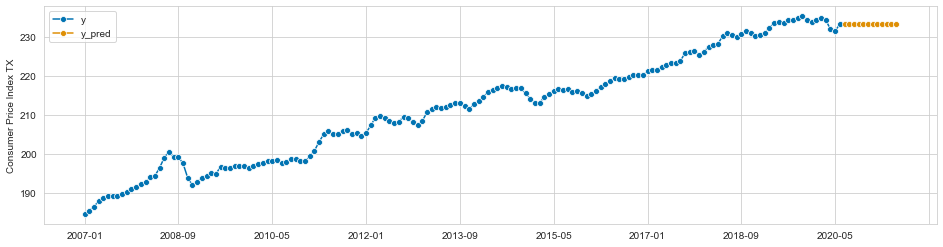

In [25]:
# step 1: data specification
y = train['Consumer Price Index TX']

# step 2: specifying forecasting horizon
fh = np.arange(1, 13)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last")

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"]);

In [26]:
error_func(y_pred, y_val)

mean absolute error : 5.04275000000001
mean root square error: 6.51639584049343
mean absolute percentage error 0.02161913622060076


In [27]:
error_df.loc['Naive'] = error_list(y_pred, y_val)

## 5.2 Naive Forecaster - Last 12 periods

In [28]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

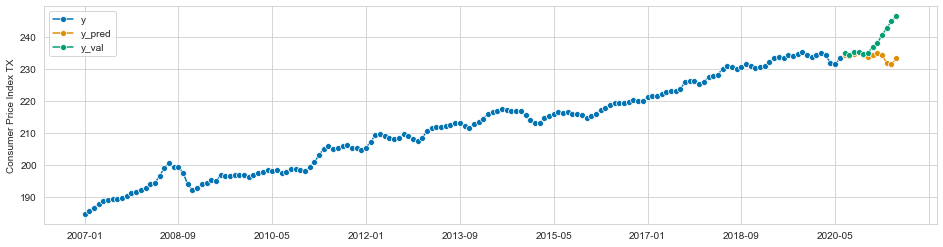

In [29]:
# step 1: data specification
y = train['Consumer Price Index TX']

# step 2: specifying forecasting horizon
fh = np.arange(1, 13)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, y_val, labels=["y", "y_pred",'y_val']);

In [30]:
error_func(y_pred, val['Consumer Price Index TX'])

mean absolute error : 4.4458333333333355
mean root square error: 6.6965961751723775
mean absolute percentage error 0.019097463600596193


In [31]:
error_df.loc['Naive_last_12'] = error_list(y_pred, y_val)

## 5.3. Multivariate - VAR

In [32]:
from sktime.datasets import load_longley
from sktime.forecasting.var import VAR

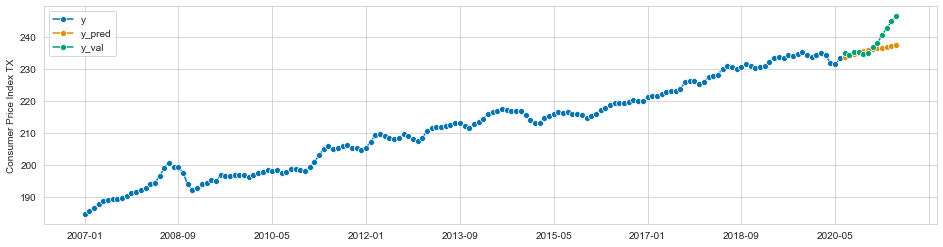

In [33]:
# step 1: data specification
y = train[['Consumer Price Index TX','Consumer Price Index U.S.']]

# step 2: specifying forecasting horizon
fh = np.arange(1, 13)

# step 3: specifying the forecasting algorithm
forecaster = VAR()

# step 4: fitting the forecaster
forecaster.fit(y,fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict()
# optional: plotting predictions and past data
plot_series(y['Consumer Price Index TX'], y_pred['Consumer Price Index TX'], y_val, labels=["y", "y_pred",'y_val']);

In [34]:
error_func(y_pred['Consumer Price Index TX'], y_val)

mean absolute error : 2.7468850204866087
mean root square error: 4.073614362690097
mean absolute percentage error 0.011601585215859052


In [35]:
error_df.loc['VAR'] = error_list(y_pred['Consumer Price Index TX'], y_val)

## 5.4. ARIMA

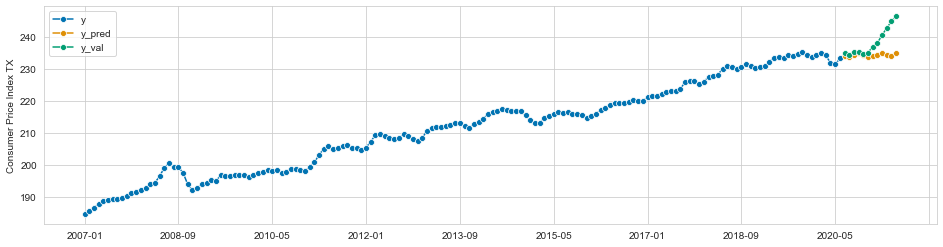

In [36]:
from sktime.forecasting.arima import ARIMA

y = train['Consumer Price Index TX']

fh = np.arange(1, 13)

forecaster = ARIMA(
    order=(1, 1, 0),
    seasonal_order=(1, 1, 0, 12),
    suppress_warnings=True)
forecaster.fit(y, fh=fh)

y_pred = forecaster.predict()

plot_series(y, y_pred, y_val, labels=["y", "y_pred",'y_val']);

In [37]:
error_func(y_pred, val['Consumer Price Index TX'])

mean absolute error : 3.995777444692133
mean root square error: 5.629026794087804
mean absolute percentage error 0.01704393085994373


In [38]:
error_df.loc['ARIMA'] = error_list(y_pred, y_val)

## 5.4. Probabilistic Forecasting

In [39]:
from sktime.forecasting.theta import ThetaForecaster

In [40]:
fh = np.arange(1, 13)

y = train['Consumer Price Index TX']

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

In [41]:
## predicting the interval
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage            
                0.9            
              lower       upper
2020-07  231.323665  235.102276
2020-08  230.708851  235.336686
2020-09  230.662590  236.006353
2020-10  230.097995  236.072504
2020-11  228.951067  235.495814
2020-12  227.953251  235.022385
2021-01  228.056575  235.613798
2021-02  228.697252  236.712897
2021-03  229.502423  237.951655
2021-04  229.900885  238.762514
2021-05  230.085463  239.341132
2021-06  230.343460  239.977066

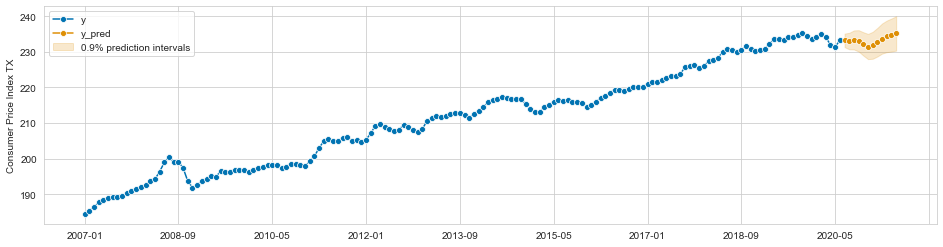

In [42]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][coverage]["lower"],
    y_pred_ints["Coverage"][coverage]["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage}% prediction intervals",
)
ax.legend();

In [43]:
error_func(y_pred, val['Consumer Price Index TX'])

mean absolute error : 5.060143486689526
mean root square error: 6.039758128277187
mean absolute percentage error 0.02164987795486671


In [44]:
error_df.loc['ThetaForecaster'] = error_list(y_pred, y_val)

## 5.5. Exponential Smoothing

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Consumer Price Index TX'>)

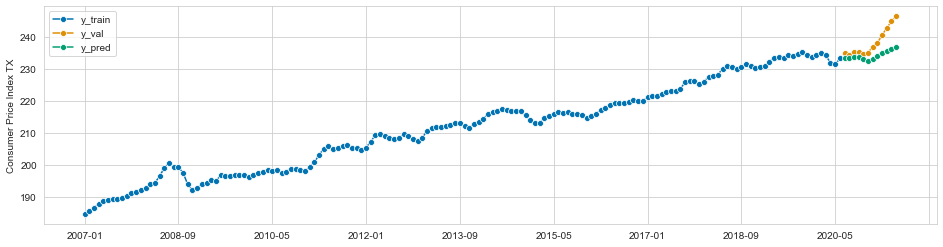

In [45]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

y = train['Consumer Price Index TX']

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_val, y_pred, labels=["y_train", "y_val", "y_pred"])

In [46]:
error_func(y_pred, val['Consumer Price Index TX'])

mean absolute error : 4.085042090540298
mean root square error: 5.015638110867676
mean absolute percentage error 0.0173793515210998


In [47]:
error_df.loc['expo_smooth'] = error_list(y_pred, y_val)

## 5.6. Auto ETS

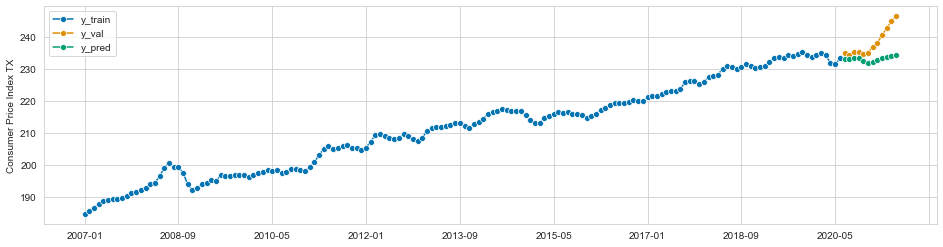

In [48]:
from sktime.forecasting.ets import AutoETS

y = train['Consumer Price Index TX']

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_val, y_pred, labels=["y_train", "y_val", "y_pred"]);

In [49]:
error_func(y_pred, val['Consumer Price Index TX'])

mean absolute error : 5.20073934611995
mean root square error: 6.358949184524426
mean absolute percentage error 0.022283296805700917


In [50]:
error_df.loc['AutoETS'] = error_list(y_pred, y_val)

## 5.7 Auto Arima

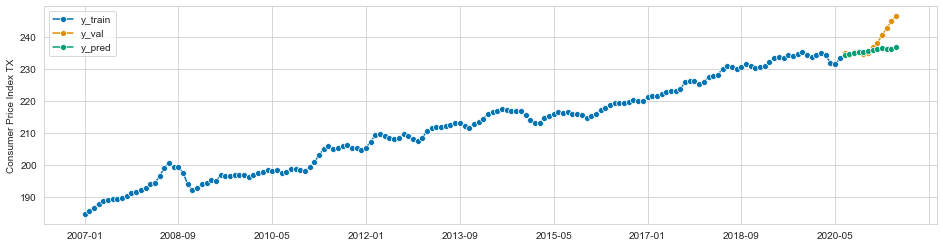

In [51]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_val, y_pred, labels=["y_train", "y_val", "y_pred"]);

In [52]:
error_func(y_pred, val['Consumer Price Index TX'])
error_df.loc['AutoARIMA'] = error_list(y_pred, y_val)

mean absolute error : 2.846178459216347
mean root square error: 4.4046404602887765
mean absolute percentage error 0.012042400337667939


## 5.8 reduction

1. Recursive strategy
The Recursive strategy trains first a one-step model and then uses it recursively for returning a multistep prediction. A well-known drawback of the recursive method is its sensitivity to the estimation error, since estimated values, instead of actual ones, are more and more used when we get further in the future.
2. Direct Strategy
The Direct strategy learns independently H models and returns a multi-step forecast by concatenating the H predictions.
does not use any approximated values and is not prone to any accumulation of errors.
since the H models are learned independently no statistical dependencies between the predictions
3. DirRec Strategy
DirRec computes the forecasts with different models for every horizon (like the Direct strategy) and, at each
time step, it enlarges the set of inputs by adding variables corresponding to the forecasts of the previous step (like the Recursive strategy). However, note that unlike the two previous strategies, the embedding size n is not the same for all the horizons.
4. MIMO Strategy.
The Multi-Input Multi-Output (MIMO) strategy (also known as Joint strategy) avoids the simplistic assumption
of conditional independence between future values made by the Direct strategy by learning a single multiple-output model.
This strategy avoids the conditional independence assumption made by the Direct strategy as well as the accumulation of errors which plagues the Recursive strategy.
5. DIRMO Strategy
The DIRMO strategy aims to preserve the most appealing aspects of DIRect and MIMO strategies by partitioning the horizon H in several blocks, and using MIMO to forecast the values inside each Machine Learning block. This means that the H-step forecast requires m multiple-output forecasting tasks (m = Hs ), each having an output of size s (s ∈ {1, . . . , H}).

In [53]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

In [54]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']

In [55]:
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

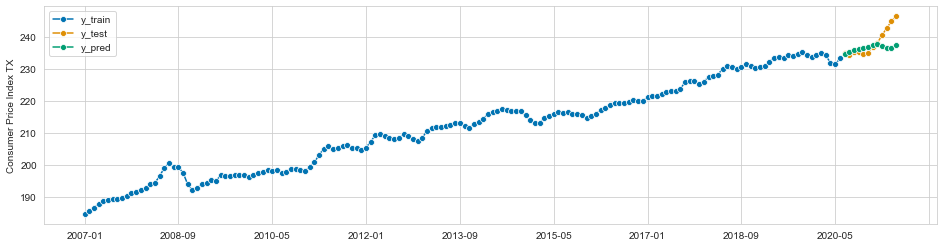

In [56]:
from sklearn.linear_model import LinearRegression

from sktime.forecasting.compose import make_reduction
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=5, strategy="multioutput")
forecaster.fit(y_train,fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [57]:
error_func(y_pred, y_val)
error_df.loc['reduction-linear'] = error_list(y_pred, y_val)

mean absolute error : 2.845692059256848
mean root square error: 4.180896079273115
mean absolute percentage error 0.01201559049633257


## 5.9. PipeLine

In [58]:
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

In [59]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']

In [60]:
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.02597586611515414

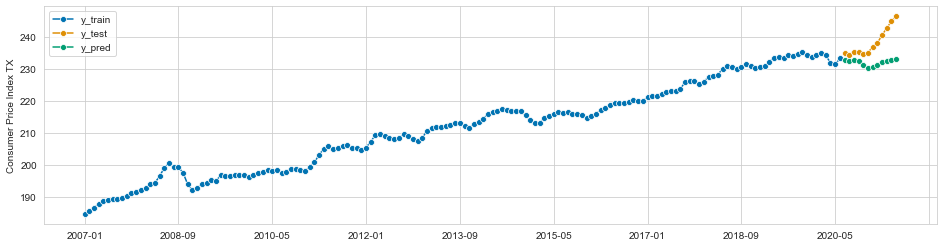

In [61]:
from xgboost import XGBRegressor

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train,fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [62]:
error_func(y_pred, y_val)
error_df.loc['seasonal_detrend'] = error_list(y_pred, y_val)

mean absolute error : 6.252251129520846
mean root square error: 7.335722170288646
mean absolute percentage error 0.02693048054030917


## 5.10. Detrender

In [63]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.compose import make_reduction

from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

In [64]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']

y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.011155414713274796

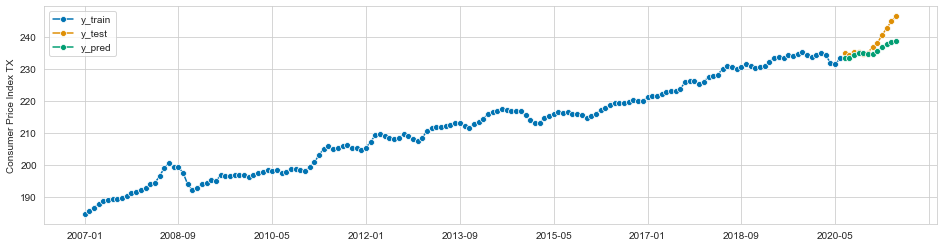

In [65]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                XGBRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [66]:
error_func(y_pred['2020-07':'2021-06'], y_val)
error_df.loc['xgb_detrend'] = error_list(y_pred['2020-07':'2021-06'], y_val)

mean absolute error : 2.6981003094039835
mean root square error: 3.6183711155789906
mean absolute percentage error 0.011380887010886985


## 5.12. Windows Splitters

https://github.com/alan-turing-institute/sktime/blob/main/examples/window_splitters.ipynb

In [67]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

In [68]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

In [69]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

In [70]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']
y_train, y_test = temporal_train_test_split(y, test_size=12)
#fh = ForecastingHorizon(y_test.index, is_relative=False)

In [71]:
# set splitter parameters
window_length = 24
fh = ForecastingHorizon(np.arange(1,13,1))

### 5.12.1. SingleWindowSplitter

In [72]:
cv = SingleWindowSplitter(window_length= window_length,fh= fh)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


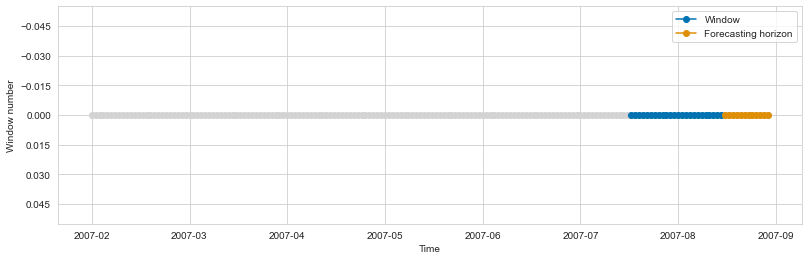

In [73]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### 5.12.2. SlidingWindowSplitter

In [74]:
cv = SlidingWindowSplitter(window_length=window_length,
                           step_length=12,
                           fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 12


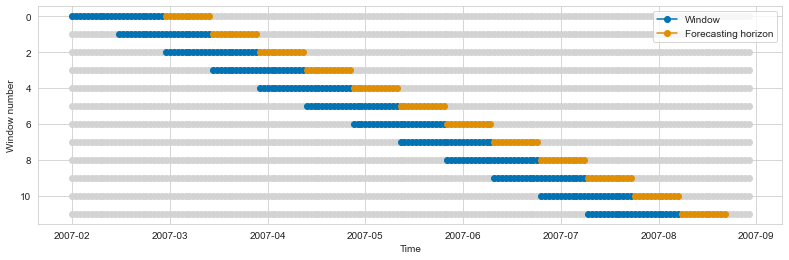

In [75]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### 5.12.3. SlidingWindowSplitter with initial window

At the moment I am not sure what is the point of this splitting strtaegy, but it would be probably helpful with updateable regressors.

In [76]:
cv = SlidingWindowSplitter(window_length=window_length,
                           step_length=12,
                           fh=fh,
                           initial_window=36)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 11


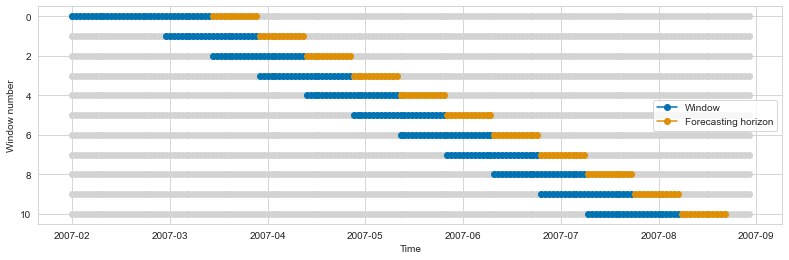

In [77]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### 5.12.3. ExpandingWindowSplitter

In [78]:
cv = ExpandingWindowSplitter(initial_window=window_length,
                             step_length=12,
                             fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 12


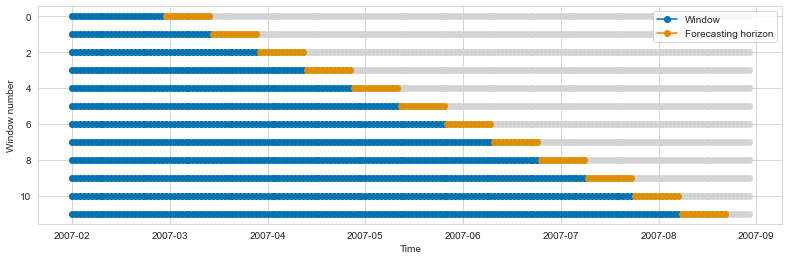

In [79]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

## 5.13. Grid search

Number of steps chosen to heavily affect the

In [80]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [81]:
y = data['Consumer Price Index TX']['2007-07':'2021-06']
y_train, y_test = temporal_train_test_split(y, test_size=12)

In [82]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

regressor = XGBRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="direct")
param_grid = {"window_length": [3, 6, 12, 15, 24, 36],
              "estimator__max_depth": [2,3,5,10]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(window_length= 36, # train size
                           step_length=12, #
                           fh= fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

gscv = ForecastingGridSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    #scoring= mean_absolute_percentage_error(),
    return_n_best_forecasters=10
)

Number of Folds = 10


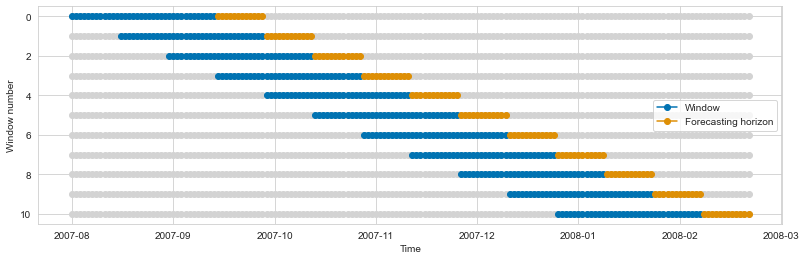

In [83]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [84]:
gscv.fit(y_train,fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True),
                                                 step_length=12,
                                                 window_length=36),
                        forecaster=DirectTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,
                                                                                            colsample_bynode=None,
                                                                                            colsample_bytree=None,
                                                                                            early_...
                                                                                            max_delta_step=None,
                                                                                            max_depth=None,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            n_estimators=100,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            predictor=None,
                                                                                            random_state=None,
                                                                                            reg_alpha=None,
                                                                                            reg_lambda=None, ...),
                                                                     window_length=15),
                        param_grid={'estimator__max_depth': [2, 3, 5, 10],
                                    'window_length': [3, 6, 12, 15, 24, 36]},
                        return_n_best_forecasters=10)

In [85]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.022667,1.518833,0.034021,"{'estimator__max_depth': 2, 'window_length': 3}",18.0
1,0.021898,1.782208,0.034841,"{'estimator__max_depth': 2, 'window_length': 6}",16.0
2,0.019735,2.005478,0.036579,"{'estimator__max_depth': 2, 'window_length': 12}",12.0
3,0.019027,1.097594,0.034558,"{'estimator__max_depth': 2, 'window_length': 15}",8.0
4,0.017828,1.061896,0.034408,"{'estimator__max_depth': 2, 'window_length': 24}",2.5
5,NaN,NaN,NaN,"{'estimator__max_depth': 2, 'window_length': 36}",NaN
6,0.022730,1.510654,0.034156,"{'estimator__max_depth': 3, 'window_length': 3}",20.0
7,0.021546,1.254883,0.032612,"{'estimator__max_depth': 3, 'window_length': 6}",15.0
8,0.019524,1.133730,0.034480,"{'estimator__max_depth': 3, 'window_length': 12}",11.0
9,0.019021,1.119525,0.035006,"{'estimator__max_depth': 3, 'window_length': 15}",7.0


In [87]:
gscv.best_params_

{'estimator__max_depth': 2, 'window_length': 24}

In [88]:
gscv.best_forecaster_

DirectTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         grow_policy=None,
                                                         importance_type=None,
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_bin=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=2,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         n_estimators=100,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         predictor=None,
                                                         random_state=None,
                                                         reg_alpha=None,
                                                         reg_lambda=None, ...),
                                  window_length=24)

0.018235821936346087

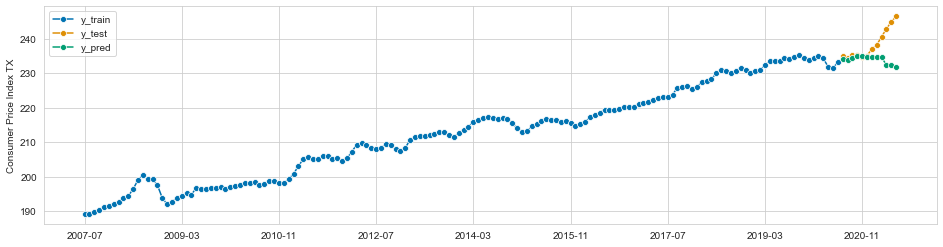

In [86]:
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## 5.13. Grid search with Detrender

Number of steps chosen to heavily affect the

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [90]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.compose import make_reduction

In [91]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']

y_train, y_test = temporal_train_test_split(y, test_size=12)

In [92]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

regressor = XGBRegressor()
base_forecaster = make_reduction(regressor, window_length=15, strategy="direct")
param_grid = {"window_length": [3, 6, 12, 15, 24, 36],
              "estimator__max_depth": [2,3,6,10]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(#window_length= 48, # train size
                           step_length=12, #
                           fh= fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

gscv = ForecastingGridSearchCV(
    base_forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    #scoring= mean_absolute_percentage_error(),
    return_n_best_forecasters=10
)

Number of Folds = 12


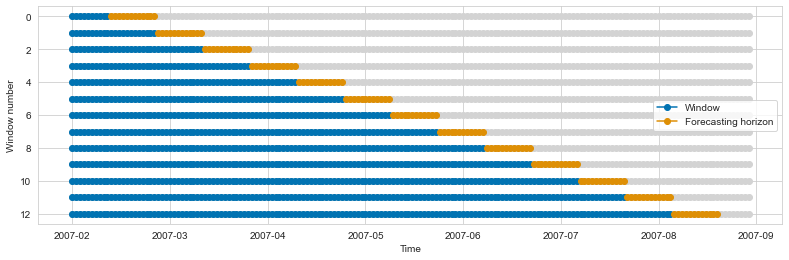

In [93]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

CPU times: total: 55min 38s
Wall time: 5min 18s


0.01425873486223591

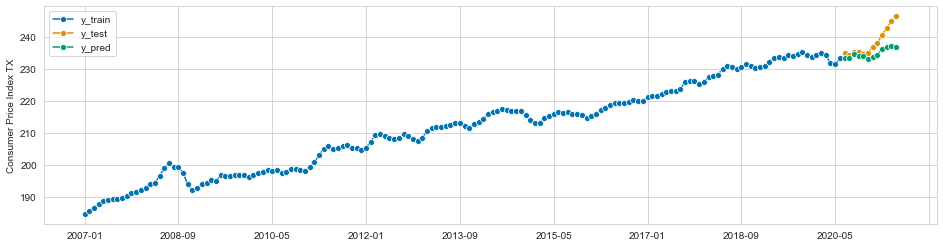

In [94]:
%%time
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", gscv),
    ]
)

forecaster.fit(y_train,fh = fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [95]:
error_func(y_pred['2020-07':'2021-06'], y_val)
error_df.loc['xgb_detrend'] = error_list(y_pred['2020-07':'2021-06'], y_val)

mean absolute error : 3.444184718491717
mean root square error: 4.451541072076258
mean absolute percentage error 0.014602586627237823


## 5.14. Grid Search with Detrender, The Other Order

Number of steps chosen to heavily affect the

In [96]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [97]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [98]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

In [99]:
y = data['Consumer Price Index TX']['2007-06':'2021-06']
y_train, y_test = temporal_train_test_split(y, test_size=12)

Since we are going to detrend the data and predict the future on the residuals of the those detrended data, we need to add the trend data back to the predictions.

In [100]:
# the trend
# number of steps in future
steps = 12
from sklearn.linear_model import LinearRegression
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_train)
y_base = y_train-y_hat

X = np.arange(1,len(y_base)+1,1).reshape(-1,1)
linear_trend = LinearRegression().fit(X, y_base)
fh = np.arange(len(y_base)+1,len(y_base)+1+steps,1).reshape(-1,1)
fh_trend = linear_trend.predict(fh)

In [101]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
y_base = y_train-y_hat

first_dif = y_base[0:steps].max() - y_base[0:steps].min()
last_dif = y_base[-steps:].max() - y_base[-steps:].min()

change_ratio = ((len(y_base)/steps + 1) / (len(y_base)/steps)) * (last_dif / first_dif)

fh_season = y_base[-steps:] * change_ratio

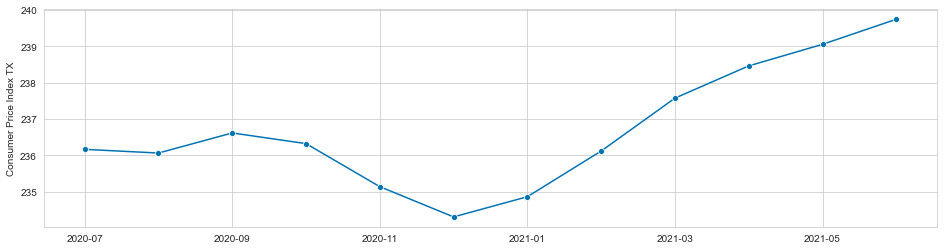

In [102]:
fh_pred_base = fh_season + fh_trend
fh_pred_base.index = y_test.index
plot_series(fh_pred_base);

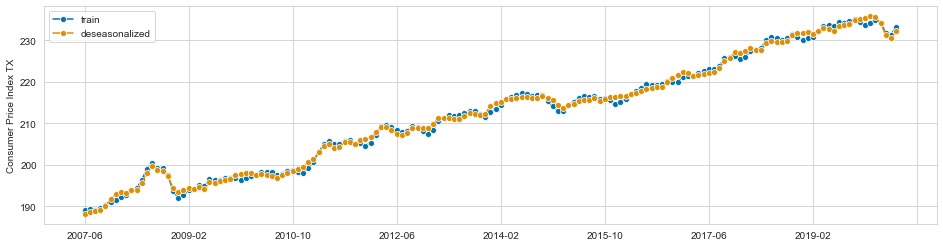

In [103]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
plot_series(y_train,y_hat, labels=["train", "deseasonalized"]);

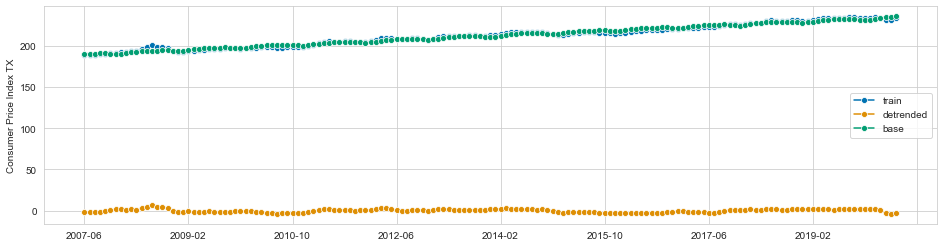

In [104]:
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_hat)
y_base = y_train - y_hat
plot_series(y_train, y_hat, y_base, labels=["train", "detrended", "base"]);

In [105]:
y_hat

2007-06   -1.528484
2007-07   -1.394835
2007-08   -1.501038
2007-09   -1.516471
2007-10   -0.749503
             ...   
2020-02    1.966223
2020-03    0.181311
2020-04   -2.989618
2020-05   -3.982350
2020-06   -2.675403
Freq: M, Length: 157, dtype: float64

In [106]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

regressor = XGBRegressor()
forecaster = make_reduction(regressor, window_length=6, strategy="direct")
param_grid = {"window_length": [3, 6, 12, 15, 24, 36],
              "estimator__max_depth": [2, 3, 5, 10]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(window_length= 36, # train size
                           step_length=12, #
                           fh= fh)

n_splits = cv.get_n_splits(y_hat)
print(f"Number of Folds = {n_splits}")

gscv = ForecastingGridSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    #scoring= mean_absolute_percentage_error(),
    return_n_best_forecasters=10
)

Number of Folds = 10


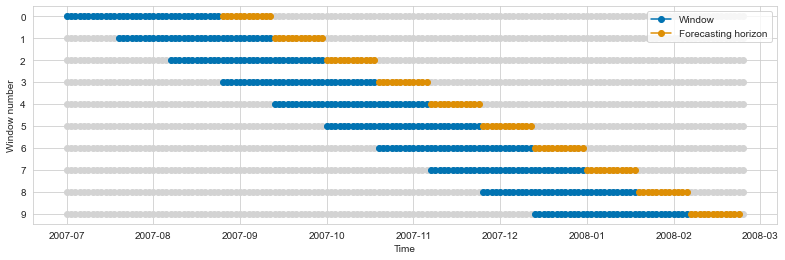

In [107]:
train_windows, test_windows = get_windows(y_hat, cv)
plot_windows(y_hat, train_windows, test_windows)

In [108]:
gscv.fit(y_hat,fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True),
                                                 step_length=12,
                                                 window_length=36),
                        forecaster=DirectTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,
                                                                                            colsample_bynode=None,
                                                                                            colsample_bytree=None,
                                                                                            early_...
                                                                                            max_delta_step=None,
                                                                                            max_depth=None,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            n_estimators=100,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            predictor=None,
                                                                                            random_state=None,
                                                                                            reg_alpha=None,
                                                                                            reg_lambda=None, ...),
                                                                     window_length=6),
                        param_grid={'estimator__max_depth': [2, 3, 5, 10],
                                    'window_length': [3, 6, 12, 15, 24, 36]},
                        return_n_best_forecasters=10)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

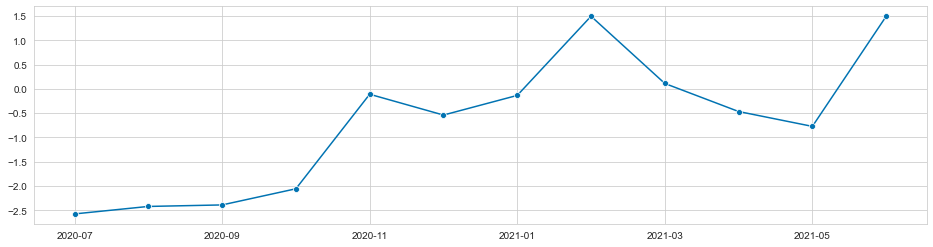

In [109]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)
y_pred = gscv.predict(fh)
plot_series(y_pred)

0.009750677159248614

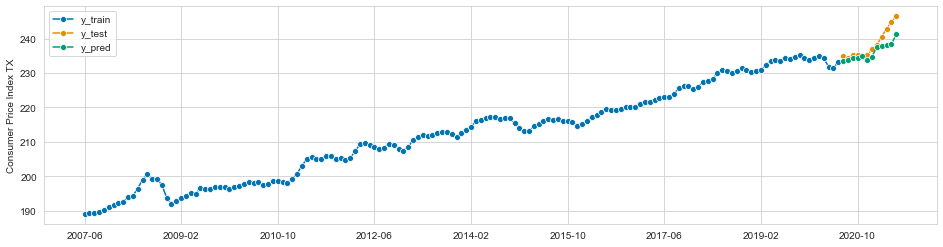

In [110]:
y_pred = gscv.predict(fh)

y_pred = y_pred + fh_pred_base

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [111]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,1.924922,1.142762,0.034432,"{'estimator__max_depth': 2, 'window_length': 3}",3.0
1,2.339934,1.143422,0.034922,"{'estimator__max_depth': 2, 'window_length': 6}",16.0
2,2.345599,1.130367,0.035260,"{'estimator__max_depth': 2, 'window_length': 12}",17.0
3,2.170768,1.128763,0.036072,"{'estimator__max_depth': 2, 'window_length': 15}",9.0
4,1.968027,1.090287,0.035162,"{'estimator__max_depth': 2, 'window_length': 24}",5.5
5,NaN,NaN,NaN,"{'estimator__max_depth': 2, 'window_length': 36}",NaN
6,1.973273,1.164851,0.034850,"{'estimator__max_depth': 3, 'window_length': 3}",8.0
7,2.336676,1.158507,0.035506,"{'estimator__max_depth': 3, 'window_length': 6}",15.0
8,2.392051,1.148959,0.035438,"{'estimator__max_depth': 3, 'window_length': 12}",18.0
9,2.228996,1.138724,0.035302,"{'estimator__max_depth': 3, 'window_length': 15}",12.0


In [112]:
gscv.best_params_

{'estimator__max_depth': 10, 'window_length': 3}

In [113]:
gscv.best_forecaster_

DirectTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         grow_policy=None,
                                                         importance_type=None,
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_bin=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=10,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         n_estimators=100,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         predictor=None,
                                                         random_state=None,
                                                         reg_alpha=None,
                                                         reg_lambda=None, ...),
                                  window_length=3)

## 5.14. Multiple Forecaster

It is intresting how the selection of cross validation window split affects the performance of the models and whihc would be the optimal.

In [ ]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

In [ ]:
forecaster.set_params(**{"selected_forecaster": "naive"})
# now forecaster behaves like NaiveForecaster(strategy="last")

In [ ]:
forecaster.set_params(**{"selected_forecaster": "ets"})
# now forecaster behaves like ExponentialSmoothing(trend="add", sp=12))

In [ ]:
forecaster.get_params()

In [ ]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

# cv = SlidingWindowSplitter(window_length= 36, # train size
#                            #step_length=3, #
#                            fh= fh)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)

# cv = ExpandingWindowSplitter(initial_window=36, fh=fh)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.best_params_

In [ ]:
gscv.cv_results_

## 5.15. Pipeline Forecaster

In [ ]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [ ]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster()),
    ]
)

# putting it all together in a grid search
cv = SlidingWindowSplitter(
                           initial_window=60,
                           window_length=24,
                           start_with_window=True,
                           step_length=6
                           )

param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}

gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_val, y_pred, labels=["y_train", "y_val", "y_pred"]);

In [ ]:
error_func(y_pred, val['Consumer Price Index TX'])
error_df.loc['AutoARIMA'] = error_list(y_pred, y_val)

Number of steps chosen to heavily affect the

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.compose import make_reduction

In [ ]:
y = data['Consumer Price Index TX']['2007-01':'2021-06']

y_train, y_test = temporal_train_test_split(y, test_size=12)

In [ ]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

regressor = XGBRegressor()
base_forecaster = make_reduction(regressor, window_length=15, strategy="direct")
param_grid = {"window_length": [3, 6, 12, 15, 24, 36],
              "estimator__max_depth": [2,3,6,10]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = ExpandingWindowSplitter(#window_length= 48, # train size
                           step_length=12, #
                           fh= fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

gscv = ForecastingGridSearchCV(
    base_forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    #scoring= mean_absolute_percentage_error(),
    return_n_best_forecasters=10
)

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
%%time
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", gscv),
    ]
)

forecaster.fit(y_train,fh = fh)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
error_func(y_pred['2020-07':'2021-06'], y_val)
error_df.loc['xgb_detrend'] = error_list(y_pred['2020-07':'2021-06'], y_val)

## 5.14. Grid Search with Detrender, with Exogenous variable, The Other Order

When predicting the target values of interest, what we have access to is all the endogenous and exogenous values up to the time the model is being built. And normally the prediction task is on a horizon longer than one time step. Howeverr most models that can use exogenous variable, need them to be known at the time the prediction being done for. To address that requirement, there are two options:
1- To predict the exogenous variables into future and fill the dataframe for its values can contain error and lead to inaccuracies in future.
2- The other possibility is to predict the value for each time step seprately, and this is what I am going to do. Since the capability is not built in the library, I have to hard code it.


In [115]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [116]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [117]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

In [275]:
from statsmodels.tsa.stattools import grangercausalitytests

In [295]:
y = data['Consumer Price Index TX']['2007-07':'2021-06']
X = data['Nonfarm Employment Texas']['2007-07':'2021-06']

Detrending the target variable

In [296]:
y = data['Consumer Price Index TX']['2007-06':'2021-06']
y_train, y_test = temporal_train_test_split(y, test_size=12)

Since we are going to detrend the data and predict the future on the residuals of the those detrended data, we need to add the trend data back to the predictions.

In [297]:
# the trend
# number of steps in future
steps = 12
from sklearn.linear_model import LinearRegression
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_train)
y_base = y_train-y_hat

X = np.arange(1,len(y_base)+1,1).reshape(-1,1)
linear_trend = LinearRegression().fit(X, y_base)
fh = np.arange(len(y_base)+1,len(y_base)+1+steps,1).reshape(-1,1)
fh_trend = linear_trend.predict(fh)

In [298]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
y_base = y_train-y_hat

first_dif = y_base[0:steps].max() - y_base[0:steps].min()
last_dif = y_base[-steps:].max() - y_base[-steps:].min()

change_ratio = ((len(y_base)/steps + 1) / (len(y_base)/steps)) * (last_dif / first_dif)

fh_season = y_base[-steps:] * change_ratio

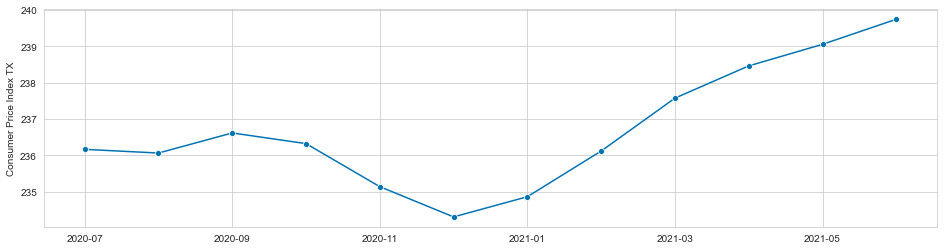

In [299]:
fh_pred_base = fh_season + fh_trend
fh_pred_base.index = y_test.index
plot_series(fh_pred_base);

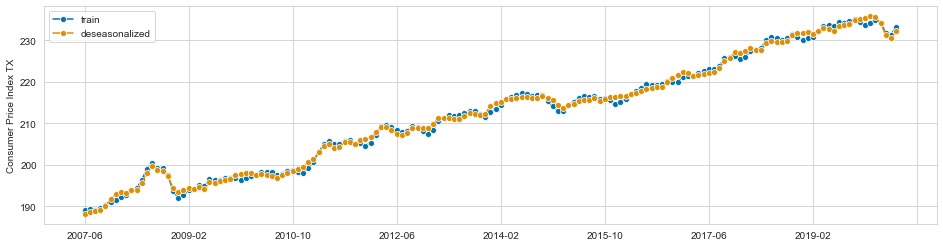

In [300]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
plot_series(y_train,y_hat, labels=["train", "deseasonalized"]);

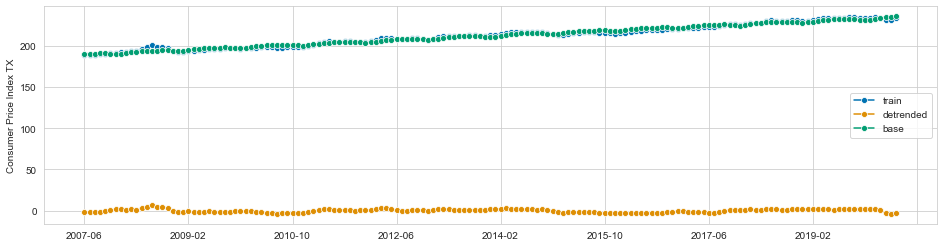

In [301]:
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_hat)
y_base = y_train - y_hat
plot_series(y_train, y_hat, y_base, labels=["train", "detrended", "base"]);

### detrending the exogenous variable

In [319]:
# selecting the exogenous variables
X = data['Gross Value Crude Oil Production']['2007-06':'2021-06']
# splitiiing the data
X_train, X_test = temporal_train_test_split(X, test_size=12)

In [320]:
# detrending the exogenous variable
# removing the seasonal trend
X_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(X_train)
# removing the linear trend
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
X_hat = transformer.fit_transform(X_hat)

### Creating the dataframes for the exogenous variables

In [321]:
Exog_train = pd.concat([y_hat, X_hat],join = 'outer', axis=1)
Exog_train.columns = ['y_hat','X_hat']
Exog_train['y_hat'] = Exog_train['y_hat'].shift(1)
Exog_train['X_hat'] = Exog_train['X_hat'].shift(1)
Exog_train = Exog_train.iloc[1:]
Exog_train

,y_hat,X_hat
2007-07,-1.528484,-498.412816
2007-08,-1.394835,-294.563850
2007-09,-1.501038,-284.162886
2007-10,-1.516471,-138.934101
2007-11,-0.749503,64.072846
...,...,...
2020-02,2.414353,2225.997042
2020-03,1.966223,1110.360639
2020-04,0.181311,-2585.404420
2020-05,-2.989618,-4998.130878


<AxesSubplot:>

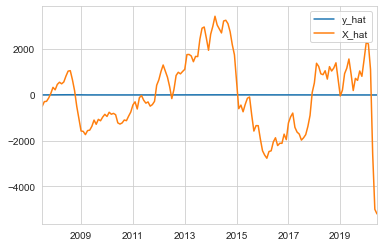

In [322]:
Exog_train.plot()

In [331]:
grangercausalitytests(Exog_train[['y_hat','X_hat']]['2007-07':'2021-06'], maxlag=1)

{1: ({'ssr_ftest': (10.828377762447568, 0.001242594384709079, 152.0, 1),
   'ssr_chi2test': (11.042095744601138, 0.0008906611986784979, 1),
   'lrtest': (10.666515357357582, 0.0010909244125339936, 1),
   'params_ftest': (10.828377762404035, 0.0012425943847363201, 152.0, 1.0)},
   array([[0., 1., 0.]])])}

feature engineering

In [334]:
# rolling average
Exog_train['y_hat_MA6'] = Exog_train['y_hat'].rolling(6).mean()
Exog_train['y_hat_MA12'] = Exog_train['y_hat'].rolling(12).mean()
Exog_train['X_hat_MA6'] = Exog_train['X_hat'].rolling(6).mean()
Exog_train['X_hat_MA12'] = Exog_train['X_hat'].rolling(12).mean()
# year over year
Exog_train['y_hat_YoY3'] = Exog_train['y_hat'].pct_change(3)
Exog_train['y_hat_YoY12'] = Exog_train['y_hat'].pct_change(12)
Exog_train['X_hat_YoY3'] = Exog_train['X_hat'].pct_change(3)
Exog_train['X_hat_YoY12'] = Exog_train['X_hat'].pct_change(12)

In [336]:
Exog_train.dropna(inplace=True)
Exog_train.head()

,y_hat,X_hat,y_hat_MA6,y_hat_MA12,X_hat_MA6,X_hat_MA12,y_hat_YoY3,y_hat_YoY12,X_hat_YoY3,X_hat_YoY12
2008-07,4.901825,1036.335012,2.244817,0.867728,650.597954,316.356065,2.190568,-4.206984,1.153029,-3.079270
2008-08,6.380823,1054.850185,3.031228,1.515699,750.362520,428.807234,4.061940,-5.574608,0.876651,-4.581058
2008-09,5.005626,656.813745,3.654638,2.057921,768.207678,507.221954,0.760897,-4.334777,-0.196870,-3.311399
2008-10,4.562004,178.312433,4.158914,2.564461,717.703402,533.659165,-0.069325,-4.008303,-0.827939,-2.283432
2008-11,2.951633,-503.914589,4.440761,2.872889,540.035650,486.326879,-0.537421,-4.938121,-1.477712,-8.864714
...,...,...,...,...,...,...,...,...,...,...
2020-02,2.414353,2225.997042,2.165984,1.901584,1417.528335,1164.941690,-0.004820,0.194244,1.751267,9.775617
2020-03,1.966223,1110.360639,2.208419,1.947685,1497.380548,1180.386741,-0.178595,0.391519,-0.270081,0.200364
2020-04,0.181311,-2585.404420,1.941832,1.822023,892.695612,868.193951,-0.920103,-0.892668,-2.136477,-3.227052
2020-05,-2.989618,-4998.130878,1.039222,1.393106,-75.172985,321.288220,-2.238269,-2.385761,-3.245345,-4.194229


### Predicting the value for the future horizons

In [338]:
list_y_pred = []

for i in range(1,13):
    fh = ForecastingHorizon([i],
                            is_relative= True)

    regressor = XGBRegressor()
    forecaster = make_reduction(regressor, window_length=6, strategy="direct")
    param_grid = {"window_length": [3, 6, 12, 15, 24, 36],
                  "estimator__max_depth": [2, 3, 5, 10]}

    # We fit the forecaster on an initial window which is 80% of the historical data
    # then use temporal sliding window cross-validation to find the optimal hyper-parameters
    cv = SlidingWindowSplitter(window_length= 36, # train size
                               step_length=12, #
                               fh= fh)

    n_splits = cv.get_n_splits(y_hat)
    print(f"Number of Folds = {n_splits}")

    gscv = ForecastingGridSearchCV(
        forecaster,
        strategy="refit",
        cv=cv,
        param_grid=param_grid,
        scoring= MeanAbsolutePercentageError(symmetric=True),
        return_n_best_forecasters=10
    )

    gscv.fit(y= y_hat[Exog_train.index],
             X= Exog_train,
             fh=fh)

    y_pred = gscv.predict(fh)

    print(f"Predicted value for {i} steps ahead: {y_pred}")

    list_y_pred.append(y_pred)

In [339]:
y_pred = pd.concat(list_y_pred, axis=0)

0.014436650842654795

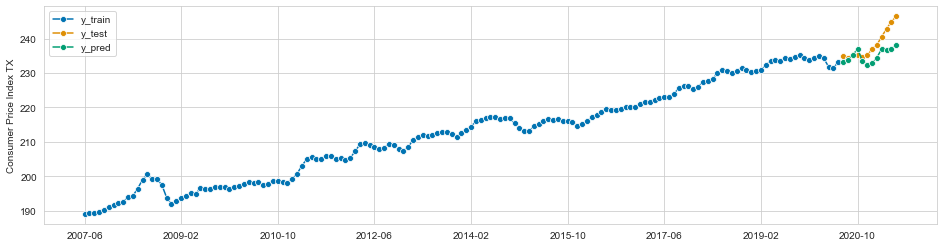

In [340]:
y_pred = y_pred + fh_pred_base

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

Number of steps chosen to heavily affect the

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [11]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [12]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

In [63]:
y = data['Consumer Price Index TX']['2007-06':'2021-06']
y_train, y_test = temporal_train_test_split(y, test_size=12)

Since we are going to detrend the data and predict the future on the residuals of the those detrended data, we need to add the trend data back to the predictions.

In [64]:
# the trend
# number of steps in future
steps = 12
from sklearn.linear_model import LinearRegression
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_train)
y_base = y_train-y_hat

X = np.arange(1,len(y_base)+1,1).reshape(-1,1)
linear_trend = LinearRegression().fit(X, y_base)
fh = np.arange(len(y_base)+1,len(y_base)+1+steps,1).reshape(-1,1)
fh_trend = linear_trend.predict(fh)

In [65]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
y_base = y_train-y_hat

first_dif = y_base[0:steps].max() - y_base[0:steps].min()
last_dif = y_base[-steps:].max() - y_base[-steps:].min()

change_ratio = ((len(y_base)/steps + 1) / (len(y_base)/steps)) * (last_dif / first_dif)

fh_season = y_base[-steps:] * change_ratio

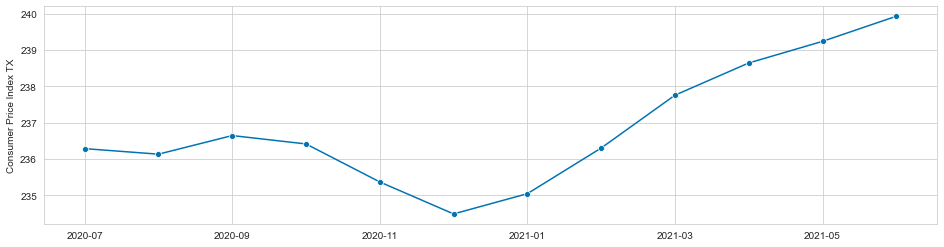

In [67]:
fh_pred_base = fh_season + fh_trend
fh_pred_base.index = y_test.index
plot_series(fh_pred_base);

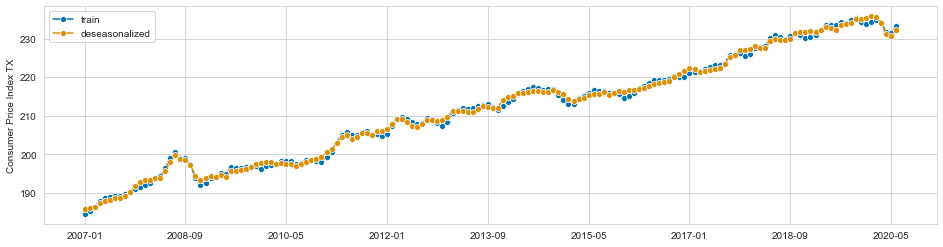

In [69]:
y_hat = Deseasonalizer(model="multiplicative", sp=12).fit_transform(y_train)
plot_series(y_train,y_hat, labels=["train", "deseasonalized"]);

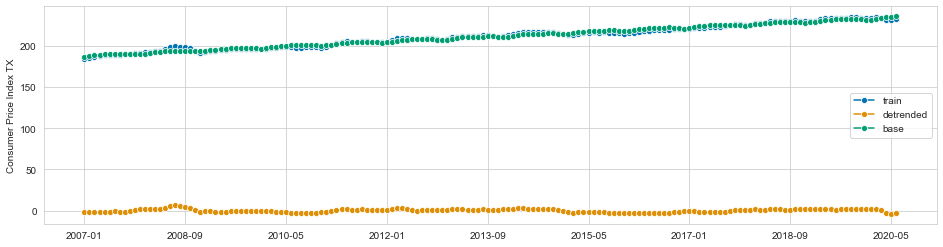

In [70]:
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
y_hat = transformer.fit_transform(y_hat)
y_base = y_train - y_hat
plot_series(y_train, y_hat, y_base, labels=["train", "detrended", "base"]);

In [89]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

regressor = XGBRegressor()
forecaster = make_reduction(regressor, window_length=6, strategy="direct")
param_grid = {"window_length": [3, 6],#, 12, 15, 24, 36],
              "estimator__max_depth": [2,3]}#,5,10]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper-parameters
cv = SlidingWindowSplitter(window_length= 36, # train size
                           step_length=12, #
                           fh= fh)

n_splits = cv.get_n_splits(y_hat)
print(f"Number of Folds = {n_splits}")

gscv = ForecastingGridSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_grid=param_grid,
    #scoring= mean_absolute_percentage_error(),
    return_n_best_forecasters=10
)

Number of Folds = 10


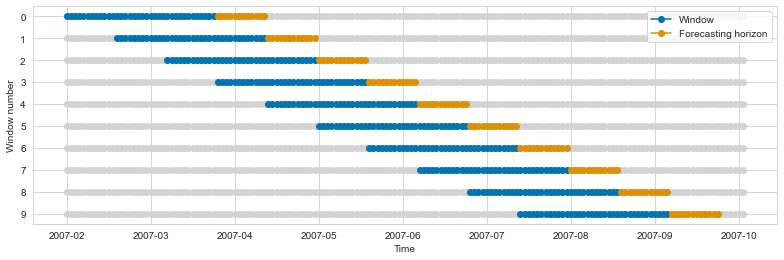

In [90]:
train_windows, test_windows = get_windows(y_hat, cv)
plot_windows(y_hat, train_windows, test_windows)

In [96]:
gscv.fit(y_train,fh=fh)

IndexError: single positional indexer is out-of-bounds

In [ ]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)
y_pred = gscv.predict(fh)
plot_series(y_pred)

In [ ]:
y_pred = gscv.predict(fh)

y_pred = y_pred + fh_pred_base

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.cv_results_

In [ ]:
gscv.best_params_

In [ ]:
gscv.best_forecaster_

## 5.14. Multiple Forecaster

It is intresting how the selection of cross validation window split affects the performance of the models and whihc would be the optimal.

In [40]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [41]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

In [42]:
forecaster.set_params(**{"selected_forecaster": "naive"})
# now forecaster behaves like NaiveForecaster(strategy="last")

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

In [43]:
forecaster.set_params(**{"selected_forecaster": "ets"})
# now forecaster behaves like ExponentialSmoothing(trend="add", sp=12))

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='ets')

In [44]:
forecaster.get_params()

{'forecasters': [('naive', NaiveForecaster()),
  ('ets', ExponentialSmoothing(sp=12, trend='add'))],
 'selected_forecaster': 'ets',
 'naive': NaiveForecaster(),
 'ets': ExponentialSmoothing(sp=12, trend='add'),
 'naive__sp': 1,
 'naive__strategy': 'last',
 'naive__window_length': None,
 'ets__damped_trend': False,
 'ets__damping_trend': None,
 'ets__initial_level': None,
 'ets__initial_seasonal': None,
 'ets__initial_trend': None,
 'ets__initialization_method': 'estimated',
 'ets__method': None,
 'ets__minimize_kwargs': None,
 'ets__optimized': True,
 'ets__random_state': None,
 'ets__remove_bias': False,
 'ets__seasonal': None,
 'ets__smoothing_level': None,
 'ets__smoothing_seasonal': None,
 'ets__smoothing_trend': None,
 'ets__sp': 12,
 'ets__start_params': None,
 'ets__trend': 'add',
 'ets__use_boxcox': None,
 'ets__use_brute': True}

In [68]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

# cv = SlidingWindowSplitter(window_length= 36, # train size
#                            #step_length=3, #
#                            fh= fh)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)

# cv = ExpandingWindowSplitter(initial_window=36, fh=fh)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

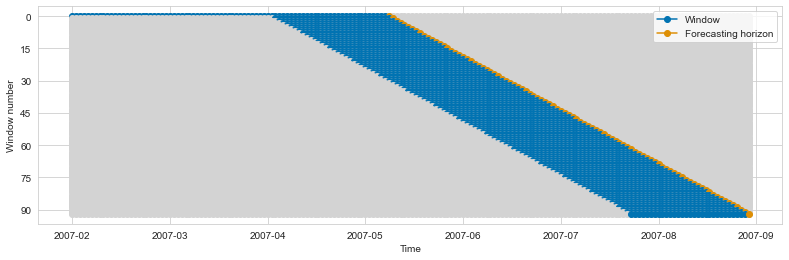

In [69]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

0.012773294699361575

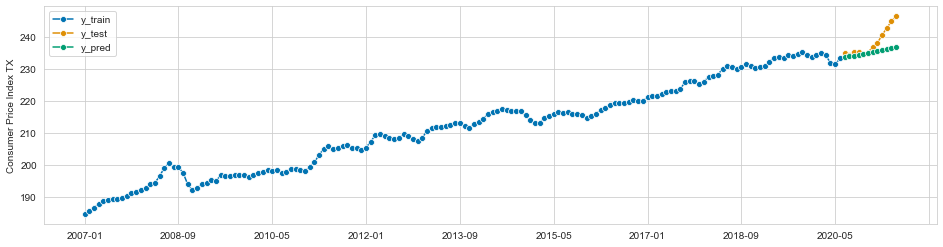

In [70]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [71]:
gscv.best_params_

{'selected_forecaster': 'ets'}

In [72]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.002876,0.023445,0.002887,{'selected_forecaster': 'ets'},1.0
1,0.003023,0.004034,0.001901,{'selected_forecaster': 'naive'},2.0


## 5.15. Pipeline Forecaster

In [23]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [126]:
fh = ForecastingHorizon(np.arange(1,13,1),
                        is_relative= True)

pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster()),
    ]
)

# putting it all together in a grid search
cv = SlidingWindowSplitter(
                           initial_window=60,
                           window_length=24,
                           start_with_window=True,
                           step_length=6
                           )

param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}

gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

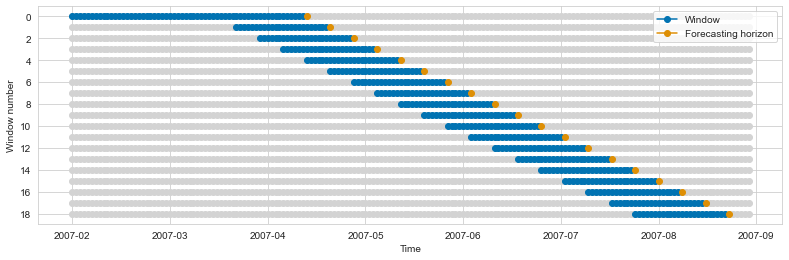

In [127]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

0.01277325271030476

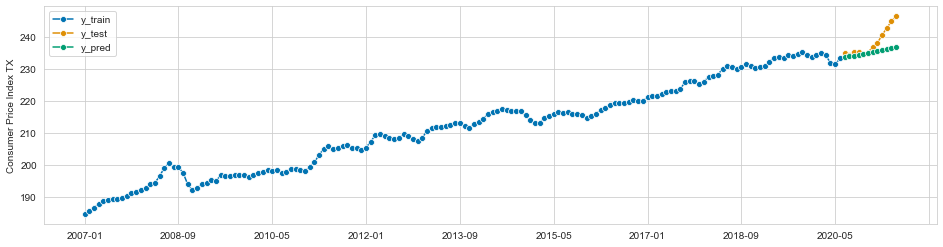

In [128]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

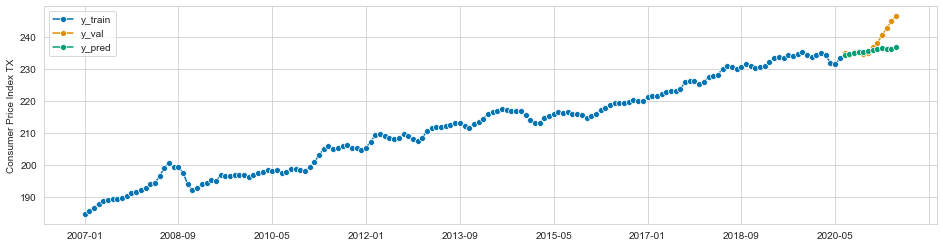

In [41]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_val, y_pred, labels=["y_train", "y_val", "y_pred"]);

In [42]:
error_func(y_pred, val['Consumer Price Index TX'])
error_df.loc['AutoARIMA'] = error_list(y_pred, y_val)

mean absolute error : 2.8461784041481715
mean root square error: 4.404640357003927
mean absolute percentage error 0.012042400096435204


# 5. Skforecast

## 5.a. Recursive multi-step forecasting
Since the value of $t_{n−1}$ is required to predict $t_{n}$, and $t_{n−1}$ is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting.
<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-recursive-mutistep-forecasting.png" width="800">

## 5.b. ForecasterAutoregMultiOutput
The model is trained for each step that has to be predicted. This strategy, commonly known as direct multistep forecasting, is computationally more expensive than the recursive since it requires training several models. However, in some scenarios, it achieves better results.

One advantage is that we can use exogenous variables without the need to predict them for the future directly.

To train a ForecasterAutoregMultiOutput a different training matrix is created for each model.

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-direct-multi-step-forecasting.png" width="800">

## 5.c. Backtesting with refit and increasing training size (fixed origin)
The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-backtesting-refit.png" width="700">

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/backtesting_refit.gif" width="700">

## 5.d. Backtesting with refit and fixed training size (rolling origin)
A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-backtesting-refit-fixed-train-size.png" width="700">

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/backtesting_refit_fixed_train_size.gif" width="700">


## 5.e. Backtesting without refit

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest information available, so it may lose predictive capacity over time.

<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-backtesting-no-refit.png" width="700">
<img src="https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/backtesting_no_refit.gif" width="700">


## 5.f. Grid search forecaster
Skforecast library combines grid search strategy with backtesting to identify the combination of lags and hyperparameters that achieve the best prediction performance.

The grid search requires two grids, one with the different lags configuration (lags_grid) and the other with the list of hyperparameters to be tested (param_grid). The process comprises the following steps:

grid_search_forecaster creates a copy of the forecaster object and replaces the lags argument with the first option appearing in lags_grid.

The function validates all combinations of hyperparameters presented in param_grid by backtesting.

The function repeats these two steps until it runs through all the possibilities (lags + hyperparameters).

If return_best = True, the original forecaster is trained with the best lags and hyperparameters configuration found.

In [ ]:
import sktime

## 5.1. Recursive Multi Step - Grid Search - Univariate - RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [ ]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags      = 12 # the value is a Placeholder and will be overwritten
)

# Lags used as predictors
lags_grid = [2, 3, 5, 6, 9, 12]#, 18, 24, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# prevents progress report
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

results_grid = grid_search_forecaster(
    forecaster  = forecaster,
    y           = train.loc['2007-01-01':, 'Consumer Price Index TX'], # Train data Only
    param_grid  = param_grid,
    lags_grid   = lags_grid,
    steps       = 12,
    refit       = True,
    metric      = 'mean_squared_error',
    initial_train_size = 24,#int(len(train)*.5), # Not sure what it is, should be larger than the lag_grid values
    fixed_train_size   = False,
    return_best = True,
    verbose     = False
)

In [ ]:
results_grid

In [ ]:
forecaster

In [ ]:
forecaster.get_feature_importance()

In [ ]:
X_train_matrix, y_train_matrix = forecaster.create_train_X_y(data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'])
X_train_matrix

In [ ]:
# Predictions
# ==============================================================================
val_pred = forecaster.predict(steps=12)

In [ ]:
help(grid_search_forecaster)

In [ ]:
val_pred

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['xgb'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 5.2. Recursive Multi Step - Grid Search - Univariate - XGB

In [ ]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [ ]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=123),
    lags      = 12 # the value is a Placeholder and will be overwritten
)

# Lags used as predictors
lags_grid = [2, 3, 5, 6, 9, 12]#, 18, 24, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# prevents progress report
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

results_grid = grid_search_forecaster(
    forecaster  = forecaster,
    y           = train.loc['2007-01-01':, 'Consumer Price Index TX'], # Train data Only
    param_grid  = param_grid,
    lags_grid   = lags_grid,
    steps       = 12,
    refit       = True,
    metric      = 'mean_squared_error',
    initial_train_size = 24,#int(len(train)*.5), # Not sure what it is, should be larger than the lag_grid values
    fixed_train_size   = False,
    return_best = True,
    verbose     = False
)

In [ ]:
results_grid

In [ ]:
forecaster

In [ ]:
forecaster.get_feature_importance()

In [ ]:
X_train_matrix, y_train_matrix = forecaster.create_train_X_y(data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'])
X_train_matrix

In [ ]:
# Predictions
# ==============================================================================
val_pred = forecaster.predict(steps=12)

In [ ]:
help(grid_search_forecaster)

In [ ]:
val_pred

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['xgb'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 5.1.initial model

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

In [ ]:
# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=42),
    lags = 24
)

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500, 700, 1000],
    'max_depth': [3, 5, 7 ,10],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Lags used as predictors
lags_grid = [3, 6, 12, 18, [1, 2, 3, 6, 12, 24]]


results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'], # Train and validation data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(train)), # Model is trained with trainign data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

In [ ]:
forecaster.get_feature_importance()

In [ ]:
X_train_matrix, y_train_matrix = forecaster.create_train_X_y(data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'])
X_train_matrix.head()

In [ ]:
# Backtesting
# ==============================================================================
metric, val_pred = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'],
    initial_train_size = len(train),
    fixed_train_size   = False,
    steps      = 12,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Backtest error: {metric}")

In [ ]:
# Predictions
# ==============================================================================
val_pred

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['xgb'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 4.8. Gradient Boosting with Exogenous Variables

In [ ]:
[*data.columns[data.loc['2007-01-01':'2021-06-01',:].isna().sum()<1]]

In [ ]:
# variables = ['Consumer Price Index TX','Consumer Confidence Index US','Unemployment U.S.']
variables = [*data.columns[data.loc['2007-01-01':'2021-06-01',:].isna().sum()<1]]
gb_df = data.loc['2007-01-01':'2021-06-01', variables]
target_var = 'Consumer Price Index TX'
variables.remove('Consumer Price Index TX')
exog_variables = variables
gb_df[exog_variables] = gb_df[exog_variables].shift(1)
gb_df = gb_df.iloc[1:,:]

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=42),
    lags = 24
)

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500, 700, 1000],
    'max_depth': [3, 5, 7 ,10],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Lags used as predictors
lags_grid = [3, 6, 12, 18, [1, 2, 3, 6, 12, 24]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = gb_df.loc[:, target_var],
    exog               = gb_df.loc[:, exog_variables],
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(gb_df.iloc[:-12,:])),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

In [ ]:
# Backtesting
# ==============================================================================
metric, val_pred = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = gb_df['Consumer Price Index TX'],
    exog               = gb_df[exog_variables],
    initial_train_size = int(len(gb_df.iloc[:-12,:])),
    fixed_train_size   = False,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

In [ ]:
forecaster.get_feature_importance().sort_values('importance',ascending=False)

reducing the number of exogenous variables

In [ ]:
variables = ['Consumer Price Index TX', 'Existing Single Family Home Price TX', 'Consumer Price Index U.S.']
gb_df = data.loc['2007-01-01':'2021-06-01', variables]
target_var = 'Consumer Price Index TX'
variables.remove('Consumer Price Index TX')
exog_variables = variables
gb_df[exog_variables] = gb_df[exog_variables].shift(1)
gb_df = gb_df.iloc[1:,:]

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=42),
    lags = 24
)

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500, 700, 1000],
    'max_depth': [3, 5, 7 ,10],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Lags used as predictors
lags_grid = [3, 4, 5, 6, 7, 8, 12, 18, [1, 2, 3, 6, 12, 24]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = gb_df.loc[:, target_var],
    exog               = gb_df.loc[:, exog_variables],
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(gb_df.iloc[:-12,:])),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

In [ ]:
# Backtesting
# ==============================================================================
metric, val_pred = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = gb_df['Consumer Price Index TX'],
    exog               = gb_df[exog_variables],
    initial_train_size = int(len(gb_df.iloc[:-12,:])),
    fixed_train_size   = False,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

In [ ]:
forecaster.get_feature_importance().sort_values('importance',ascending=False)

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['gb_exo'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 4.9. Gradient Boosting with skforecast LightGBM

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

In [ ]:
# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=42),
    lags = 24
)

forecaster

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500, 700, 1000],
    'max_depth': [3, 5, 7 ,10],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Lags used as predictors
lags_grid = [3, 6, 12, 18, [1, 2, 3, 6, 12, 24]]


results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'], # Train and validation data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 12,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(train)), # Model is trained with trainign data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

In [ ]:
# Backtesting
# ==============================================================================
metric, val_pred = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.loc['2007-01-01':'2021-06-01', 'Consumer Price Index TX'],
    initial_train_size = len(train),
    fixed_train_size   = False,
    steps      = 12,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Backtest error: {metric}")

In [ ]:
# Predictions
# ==============================================================================
val_pred

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['lgb'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 5.6. Multi Output

In [ ]:
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import Ridge

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
    regressor = Ridge(),
    steps     = 12,
    lags      = 15
)

In [ ]:
# fitting the model
# ==============================================================================
forecaster.fit(y= data.iloc[:-24,:]['2007-01-01':]['Consumer Price Index TX'])
forecaster

In [ ]:
# feature importance
# ==============================================================================
forecaster.get_feature_importance(step=1) # it is nessary to mention we want the imprtance at which step

In [ ]:
# Predict
# ==============================================================================
steps = 12
val_pred = forecaster.predict(steps=steps)

In [ ]:
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['multi_Ridge'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df

## 5.7. Custom Predictor

In [ ]:
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Custom function to create predictors
# ==============================================================================
def create_predictors(y,n_lag=12,n_mean=1):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 12.
    '''

    lags = y[-1:-n_lag:-1]
    mean = np.mean(y[-n_mean:])
    predictors = np.hstack([lags, mean])

    return predictors

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
    regressor      = RandomForestRegressor(random_state=123),
    fun_predictors = create_predictors,
    window_size    = 20
)

forecaster.fit(y=data_train)
forecaster

In [ ]:
forecaster.get_feature_importance()

In [ ]:
# Predict
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(3)

## 5.8. backtest forecaster

The backtesting process adapted to this scenario is:
1- backtesting_forecaster creates a copy of the forecaster object and trains the model with the length of the series set in initial_train_size.
2- It predicts and stores the next 10 steps, steps=10.
3- Since refit=True, the training set increases to a length of initial_train_size + steps, and the test data becomes the following 10 steps.
4- The model is re-trained with the new training set. The new 10 steps are then predicted.
5- This process is repeated until the entire series has been run.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags      = 15
)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.iloc[:-24,:]['2007-01-01':]['Consumer Price Index TX'],
    initial_train_size = len(data.iloc[:-36,:]['2007-01-01':]['Consumer Price Index TX']), # should be smaller than train size
    fixed_train_size   = False,
    steps      = 3,
    metric     = 'mean_squared_error',
    refit      = False,
    verbose    = True
)

In [ ]:
len(data.iloc[:-24,:]['2007-01-01':]['Consumer Price Index TX'])

## 5.9 backtest with prediction intervals
Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow for predicting the expected distribution of the outcome instead of a single future value. This type of forecasting provides much rich information since it allows for creating prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

There are multiple ways to estimate prediction intervals, most of which require that the residuals (errors) of the model follow a normal distribution. When this property cannot be assumed, two alternatives commonly used are:
    - Prediction intervals based on bootstrapped residuals and a recursive-multi-step forecaster.
    - Prediction intervals based on quantile regression and a direct-multi-step forecaster.

Prediction intervals using bootstrapped residuals
Assuming future errors will be like past errors, it is possible to simulate different predictions by sampling from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.
<img src='https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-bootstrapping-prediction-intervals.png' width='700'>

Doing this repeatedly, a collection of slightly different predictions is created (possible future paths), that represent the expected variance in the forecasting process.
<img src='https://joaquinamatrodrigo.github.io/skforecast/0.4.3/img/diagram-bootstrapping-prediction-intervals-2.png' width='700'>

The main advantage of this strategy is that it only requires a single model to estimate any interval. The drawback is that, running hundreds or thousands of bootstrapping iterations, is computationally very expensive and not always workable.

In [ ]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = Ridge(),
    lags      = 15
)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['y'],
    initial_train_size = len(data.loc[:end_train]),
    fixed_train_size   = False,
    steps      = 10,
    metric     = 'mean_squared_error',
    refit      = True,
    interval   = [5, 95],
    n_boot     = 500,
    verbose    = True
)

In [ ]:
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions_backtest['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_backtest.index,
    predictions_backtest['lower_bound'],
    predictions_backtest['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();


## Predictions on training data
Predictions on training data can be obtained either by using the backtesting_forecaster() function or by accessing the predict() method of the regressor stored inside the forecaster object.

Predict using backtesting_forecaster()


In [ ]:
Set arguments initial_train_size=None and refit=False to perform backtesting using the already trained forecaster.

In [ ]:
variables = ['Consumer Price Index TX', 'Existing Single Family Home Price TX', 'Consumer Price Index U.S.']
gb_df = data.loc['2007-01-01':'2021-06-01', variables]
target_var = 'Consumer Price Index TX'
variables.remove('Consumer Price Index TX')
exog_variables = variables
gb_df[exog_variables] = gb_df[exog_variables].shift(1)
gb_df = gb_df.iloc[1:, :]

In [ ]:
from pmdarima.arima  import auto_arima

auto_arima(y= gb_df['Consumer Price Index TX'][:'2020-06-01'],
           exogenous= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
           seasonal= True,
           m= 12).summary()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(endog= gb_df['Consumer Price Index TX'][:'2020-06-01'],
                exog= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
                seasonal= True,
                m= 12,
                order=(0,1,1),
                seasonal_order=(2,0,1,12))
res_fit = model.fit()
res_fit.summary()

In [ ]:

start= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])
end= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])+val.shape[0]-1
val_pred= res_fit.predict(start=start,
                                 end=end,
                                 exog = gb_df.drop('Consumer Price Index TX',axis=1).iloc[-24:-12,:],
                                 dynamic=False).rename('SARIMAX(0,1,1)(2,0,1,12) predictions')

In [ ]:
x_begin = '2017-01-01'

gb_df['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='prediction');

In [ ]:
# the model has leakage, I have to estimate observatios for the exogenous variables
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['SARIMAX'] = error_list(val['Consumer Price Index TX'], val_pred)

In [ ]:
variables = ['Consumer Price Index TX', 'Existing Single Family Home Price TX', 'Consumer Price Index U.S.']
gb_df = data.loc['2007-01-01':'2021-06-01', variables]
target_var = 'Consumer Price Index TX'
variables.remove('Consumer Price Index TX')
exog_variables = variables
gb_df[exog_variables] = gb_df[exog_variables].shift(1)
gb_df = gb_df.iloc[1:, :]

In [ ]:
from pmdarima.arima  import auto_arima

auto_arima(y= gb_df['Consumer Price Index TX'][:'2020-06-01'],
           exogenous= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
           seasonal= True,
           m= 12).summary()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(endog= gb_df['Consumer Price Index TX'][:'2020-06-01'],
                exog= gb_df.drop('Consumer Price Index TX',axis=1)[:'2020-06-01'] ,
                seasonal= True,
                m= 12,
                order=(0,1,1),
                seasonal_order=(2,0,1,12))
res_fit = model.fit()
res_fit.summary()

In [ ]:

start= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])
end= len(gb_df['Consumer Price Index TX'][:'2020-06-01'])+val.shape[0]-1
val_pred= res_fit.predict(start=start,
                                 end=end,
                                 exog = gb_df.drop('Consumer Price Index TX',axis=1).iloc[-24:-12,:],
                                 dynamic=False).rename('SARIMAX(0,1,1)(2,0,1,12) predictions')

In [ ]:
x_begin = '2017-01-01'

gb_df['Consumer Price Index TX'][x_begin:].plot(legend=True,label='train')
val['Consumer Price Index TX'].plot(legend=True,label='val',figsize=(12,8))
val_pred.plot(legend=True,label='prediction');

In [ ]:
# the model has leakage, I have to estimate observatios for the exogenous variables
error_func(val['Consumer Price Index TX'], val_pred)

In [ ]:
error_df.loc['SARIMAX'] = error_list(val['Consumer Price Index TX'], val_pred)